In [2]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import hvplot.pandas
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from fuzzywuzzy import process
import requests

In [7]:
company_request = 'LYFT'

In [8]:
def getCompany(text):
    r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
    stockList = r.json()
    return process.extractOne(text, stockList)[0]

In [9]:
company = getCompany(company_request)

In [10]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

LYFT
LYFT INC-A


In [11]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 completed


In [12]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [13]:
# Your key here
key = 'EUUCJ727EVA4WPM3'
ts = TimeSeries(key)

# Chose your output format, or default to JSON (python dict)
ts = TimeSeries(key, output_format='pandas')
ti = TechIndicators(key)

# Get the data, returns a tuple
# aapl_data is a pandas dataframe, aapl_meta_data is a dict
ndaq_data, ndaq_meta_data = ts.get_daily(symbol='LYFT')
# aapl_sma is a dict, aapl_meta_sma also a dict
ndaq_sma, ndaq_meta_sma = ti.get_sma(symbol='LYFT')
ndaq_sma = ti.get_sma(symbol='LYFT')
ndaq_data.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2020-02-13,48.45,49.39,47.00,47.03,15550452.0
2020-02-12,51.25,51.30,48.42,48.46,36622805.0
2020-02-11,54.49,54.50,52.92,53.94,20414424.0
2020-02-10,50.82,53.92,50.33,53.72,15370420.0
2020-02-07,49.10,50.04,47.58,49.92,12516247.0


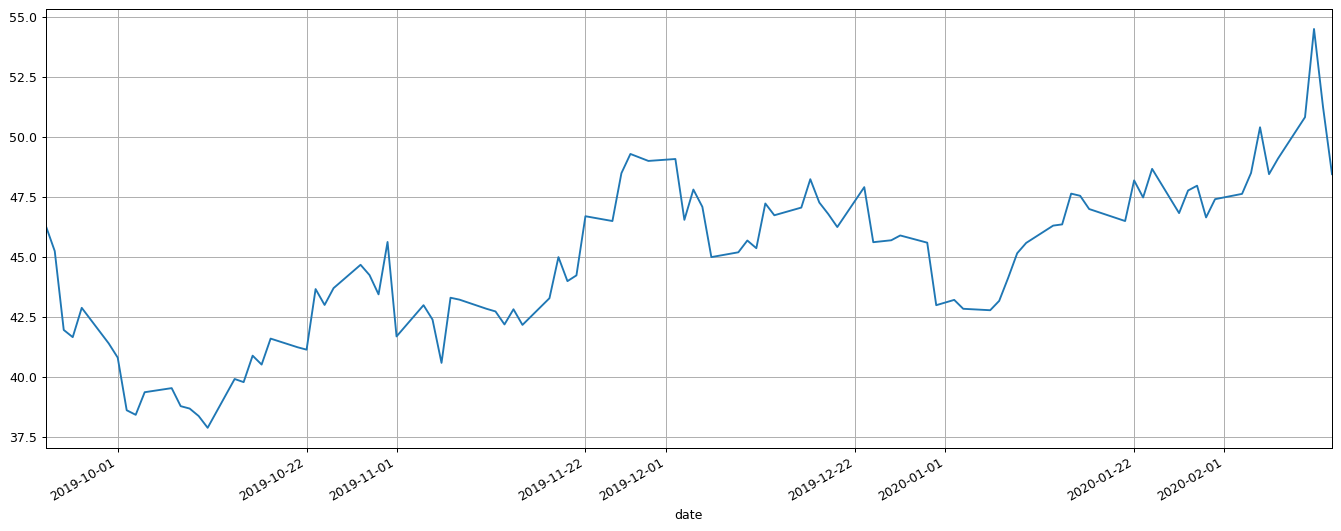

In [14]:
# Visualization closin=
figure(num=None, figsize=(15, 6), dpi=90, facecolor='w', edgecolor='k')
ndaq_data['1. open'].plot()
plt.tight_layout()
plt.grid()
plt.show()

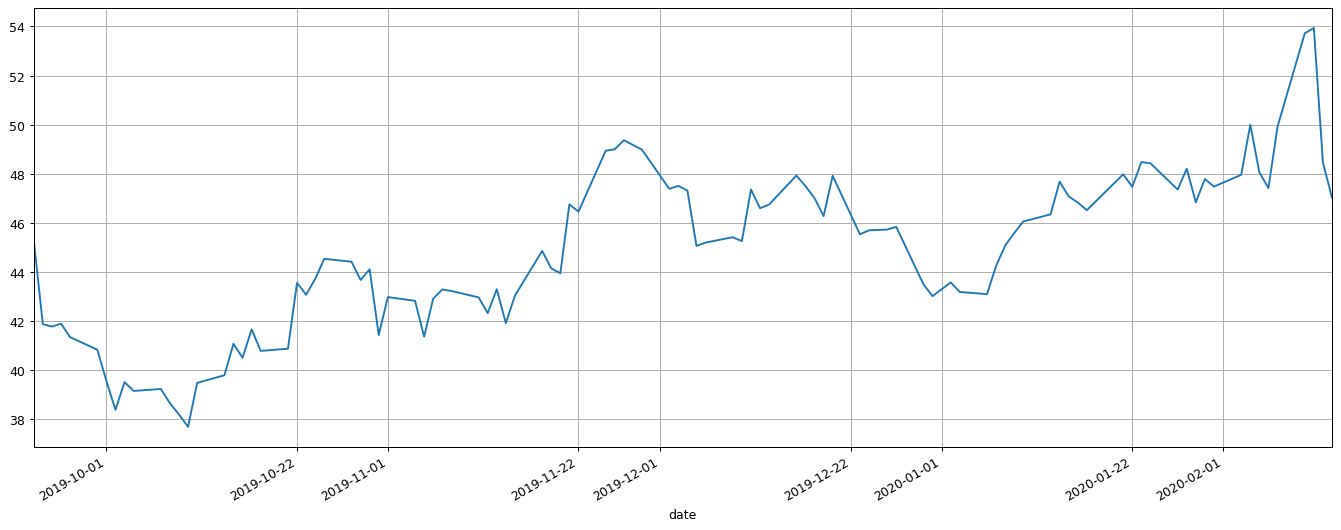

In [15]:
# Visualization closing
figure(num=None, figsize=(15, 6), dpi=90, facecolor='w', edgecolor='k')
ndaq_data['4. close'].plot()
plt.tight_layout()
plt.grid()
plt.show()

In [16]:
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()



In [17]:
# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 5
long_vol_window = 21



In [18]:
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()



In [19]:
# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']



In [20]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

# Set the short window and long windows
rolling_short_window = 50
rolling_long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
data["SMA50"] = data["Close"].rolling(window=short_window).mean()
data["SMA100"] = data["Close"].rolling(window=long_window).mean()

# Initialize the new `Signal` column
data["SMA_Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
data["SMA_Signal"][short_window:] = np.where(
    data["SMA50"][short_window:] < data["SMA100"][short_window:], 1.0, 0.0
)

data

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-29,87.330002,88.599998,78.019997,78.290001,78.290001,71485200,NaN,78.290001,78.290001,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-01,74.900002,75.000000,67.779999,69.010002,69.010002,41799300,-0.118534,73.617840,73.633921,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-02,66.900002,70.199997,66.099998,68.970001,68.970001,22483300,-0.000580,72.047034,72.068492,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-03,70.059998,72.000000,69.120003,70.000000,70.000000,15662300,0.014934,71.524585,71.545980,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-04,70.480003,72.889999,70.220001,72.000000,72.000000,9229300,0.028571,71.622322,71.638047,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


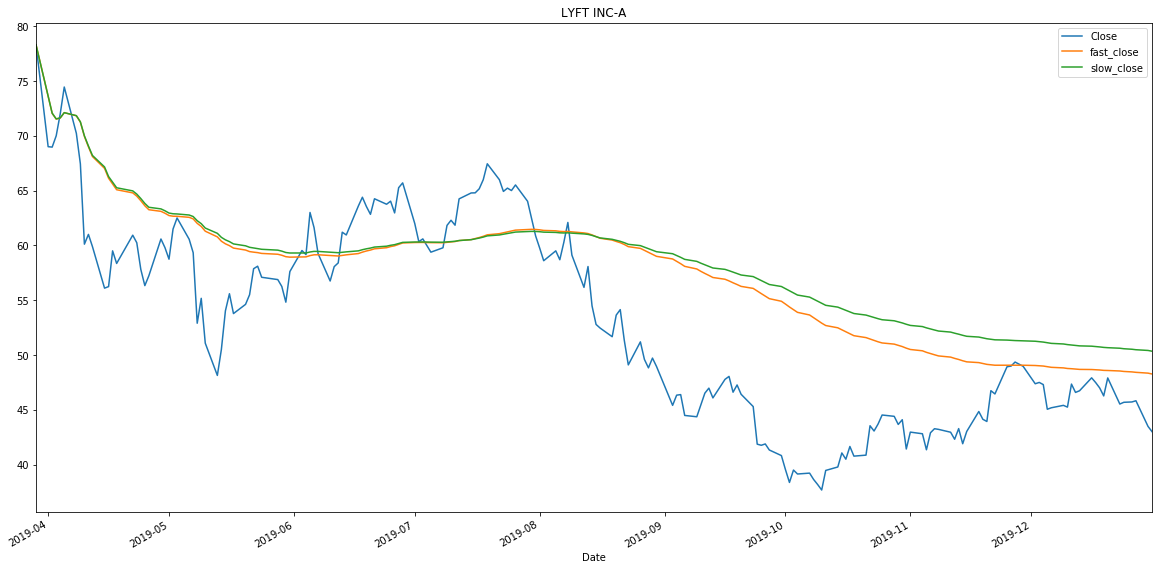

In [21]:

data.loc['2000-01-01':'2020-01-01'][['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

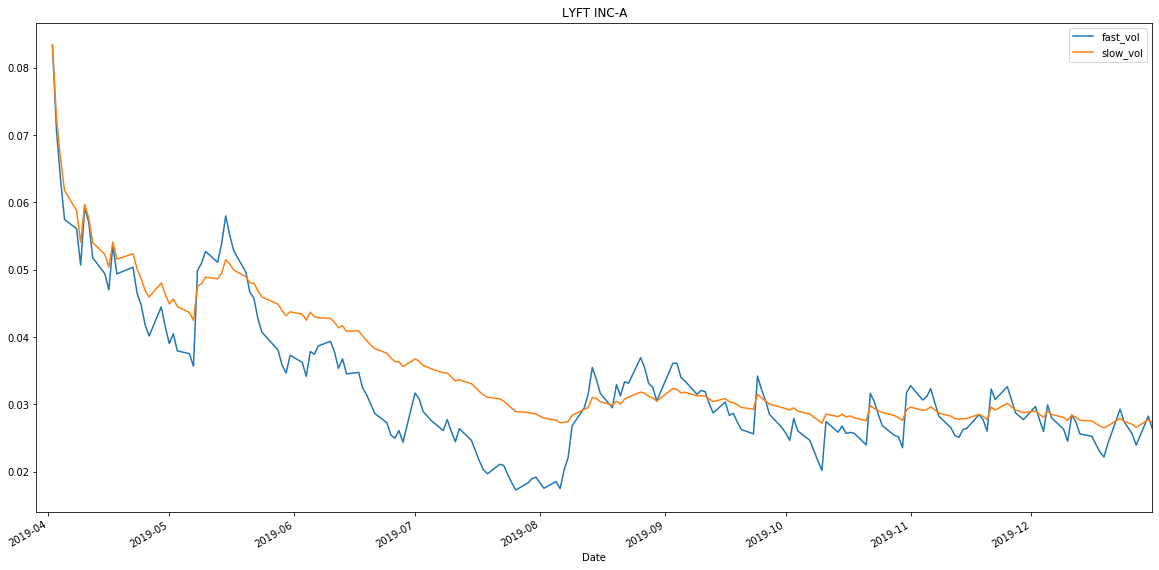

In [22]:
data.loc['2000-01-01':'2020-01-01'][['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

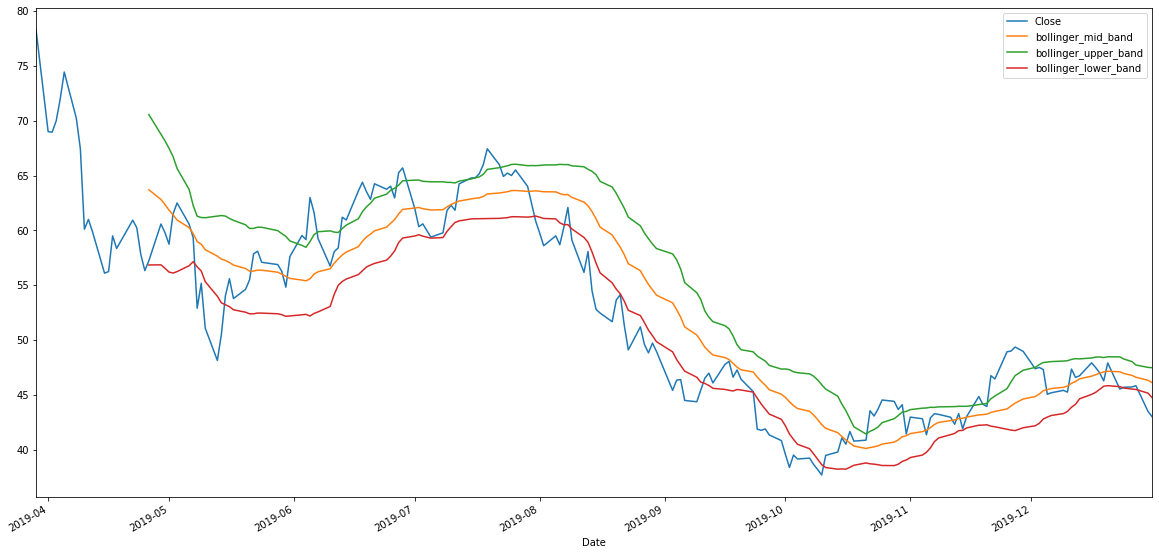

In [23]:
# Plot the Bollinger Bands for BTC/USD closing prices
data.loc['2014-01-01':'2020-01-01'][['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [24]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'SMA_Signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2020-02-07,-1.0,-1.0,-1.0,0.0
2020-02-10,-1.0,-1.0,-1.0,0.0
2020-02-11,-1.0,-1.0,-1.0,0.0
2020-02-12,-1.0,-1.0,0.0,0.0
2020-02-13,-1.0,-1.0,0.0,0.0


In [25]:

data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2020-02-07,-1.0,-1.0,0.0,0.0
2020-02-10,-1.0,-1.0,-1.0,0.0
2020-02-11,-1.0,-1.0,-1.0,0.0
2020-02-12,-1.0,-1.0,-1.0,0.0
2020-02-13,-1.0,-1.0,0.0,0.0


In [26]:
#signal_dataand replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,74.900002,75.000000,67.779999,69.010002,69.010002,41799300,-0.118534,73.617840,73.633921,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-02,66.900002,70.199997,66.099998,68.970001,68.970001,22483300,-0.000580,72.047034,72.068492,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-03,70.059998,72.000000,69.120003,70.000000,70.000000,15662300,0.014934,71.524585,71.545980,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-04,70.480003,72.889999,70.220001,72.000000,72.000000,9229300,0.028571,71.622322,71.638047,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2019-04-05,73.940002,76.099998,73.300003,74.449997,74.449997,11200100,0.034028,72.110084,72.114864,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


In [27]:
data['Positive Return'] = np.where(data['Daily Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,74.900002,75.000000,67.779999,69.010002,69.010002,41799300,-0.118534,73.617840,73.633921,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2019-04-02,66.900002,70.199997,66.099998,68.970001,68.970001,22483300,-0.000580,72.047034,72.068492,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2019-04-03,70.059998,72.000000,69.120003,70.000000,70.000000,15662300,0.014934,71.524585,71.545980,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2019-04-04,70.480003,72.889999,70.220001,72.000000,72.000000,9229300,0.028571,71.622322,71.638047,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2019-04-05,73.940002,76.099998,73.300003,74.449997,74.449997,11200100,0.034028,72.110084,72.114864,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-07,49.099998,50.040001,47.580002,49.919998,49.919998,12516200,0.052720,47.881657,49.637029,0.0,...,1.025575,48.721575,46.670425,0.0,-1.0,0.0,46.7180,44.65855,0.0,1.0
2020-02-10,50.820000,53.919998,50.330002,53.720001,53.720001,15370400,0.076122,47.966090,49.673147,0.0,...,1.632927,49.711927,46.446073,0.0,-1.0,-1.0,46.8124,44.71515,0.0,1.0
2020-02-11,54.490002,54.500000,52.919998,53.939999,53.939999,20414400,0.004095,48.052424,49.710819,0.0,...,2.040950,50.499450,46.417550,0.0,-1.0,-1.0,46.9038,44.78835,0.0,1.0


In [28]:
split = int(0.7 * len(data))
# Construct training start and end dates
training_start = data.index.min().strftime(format= '%Y-%m-%d')
training_end = data.index[split - 1].strftime(format= '%Y-%m-%d')

# Construct testing start and end dates
testing_start =  data.index[split].strftime(format= '%Y-%m-%d')
testing_end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end} at 70% of data")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end} at latest data")

Training Start: 2019-04-01
Training End: 2019-11-06 at 70% of data
Testing Start: 2019-11-07
Testing End: 2020-02-13 at latest data


In [29]:
# Construct the x train and y train datasets
x_train = data[x_var_list][training_start:training_end]
y_train = data['Positive Return'][training_start:training_end]

x_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-10-31,-1.0,1.0,-1.0,1.0
2019-11-01,-1.0,-1.0,0.0,1.0
2019-11-04,-1.0,-1.0,0.0,1.0
2019-11-05,-1.0,-1.0,0.0,1.0
2019-11-06,-1.0,-1.0,0.0,1.0


In [30]:
# Construct the x test and y test datasets
x_test = data[x_var_list][testing_start:testing_end]
y_test = data['Positive Return'][testing_start:testing_end]

x_test.tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2020-02-07,-1.0,-1.0,0.0,0.0
2020-02-10,-1.0,-1.0,-1.0,0.0
2020-02-11,-1.0,-1.0,-1.0,0.0
2020-02-12,-1.0,-1.0,-1.0,0.0
2020-02-13,-1.0,-1.0,0.0,0.0
